<h1><center> Image classificator using a Bag Of Visual Words classifier</center></h1>

In [1]:
import os
from cv2 import cv2 as cv
import numpy as np
import requests, zipfile, io, tarfile
import shutil
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import joblib

The first thing we need to do is to get the dataset. We will download it and extract the images locally.

In [2]:
if not os.path.exists('res'):
    r = requests.get("https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1")
    files = zipfile.ZipFile(io.BytesIO(r.content))
    files.extractall('res')
    shutil.rmtree('res/__MACOSX')
    with tarfile.open("res/caltech-101/101_ObjectCategories.tar.gz", "r:gz") as tar:
        tar.extractall("res/caltech-101")
    os.remove("res/caltech-101/show_annotation.m")
    os.remove("res/caltech-101/Annotations.tar")
    os.remove("res/caltech-101/101_ObjectCategories.tar.gz")

<p>We now need to split the data in train and test folders.</p>

In [3]:
folder_path = "res/caltech-101/101_ObjectCategories"
train_path = "res/caltech-101_train"
test_path = "res/caltech-101_test"
if not os.path.exists(train_path):
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        images = [f for f in os.listdir(class_path)]
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=24)
        train_class_dir = os.path.join(train_path, class_folder)
        test_class_dir = os.path.join(test_path, class_folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))    
        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))
    shutil.rmtree('res/caltech-101')

Now that we have the data sorted, we can start creating the program. First, we create a inbetween class converter using 2 dictionaries. Also, we create the sift instance we will use.

In [4]:
class_names = []
class_to_label = {}
label_to_class = {}

for class_name in os.listdir(test_path):
    class_names.append(class_name)
for i in range(len(class_names)):
    class_to_label[class_names[i]] = i
    label_to_class[i] = class_names[i]

sift = cv.SIFT_create()

We will now create a function that will extract all the paths from a directory, as well as a function that will return the descriptors of an image's path.

In [5]:
def get_images_from_folder(path):
    return [os.path.join(path, file)
    for file in os.listdir(path)]

def extract_local_features(path):
    image = cv.imread(path)
    image = cv.resize(image, (150, 75))
    keypoints = sift.detect(image)
    descriptors = sift.compute(image, keypoints)
    return descriptors[1]

We will now create a method to create a vocabulary based on the images we will give. We will also provide a num_of_clusters parameter in case we want to test the results given different number of clusters. The process is as follows: We collect all the descriptors we can from our images and then create the vocabulary based on them.

In [6]:
def create_vocabulary(images, num_of_clusters=200):
    descriptors = []
    for path in images:
        descriptor = extract_local_features(path)
        if descriptor is not None:
            descriptors.append(descriptor)
    descriptors = np.vstack(descriptors)
    term_crit = (cv.TERM_CRITERIA_EPS, 30, 0.1)
    trainer = cv.BOWKMeansTrainer(num_of_clusters, term_crit, 1, cv.KMEANS_PP_CENTERS)
    vocabulary = trainer.cluster(descriptors.astype(np.float32))
    return vocabulary

The term_crit stands for Termination Criteria. The KNN algorithm will either stop after 30 iterations or when the cluster center movement is less than 0.1. We then want to create our BOVW descriptors based on our images. In order to do that, given a descriptor we categorize the image to the one closest to our classes.

In [7]:
def encode_BOVW_descriptor(desc, vocabulary):
    bow_desc = np.zeros((1, vocabulary.shape[0]))
    for d in range(desc.shape[0]):
        distances = np.sum((desc[d, :] - vocabulary) ** 2, axis=1)
        mini = np.argmin(distances)
        bow_desc[0, mini] += 1

    # Normalization
    if np.sum(bow_desc) > 0:
        bow_desc = bow_desc / np.sum(bow_desc)
    return bow_desc

After, we just need a general method for a set of images.

In [8]:
def create_descriptors(images, vocabulary):
    bovw_descriptors = []
    for path in images:
        descriptor = extract_local_features(path)
        if descriptor is not None:
            bovw_descriptor = encode_BOVW_descriptor(descriptor, vocabulary)
            bovw_descriptors.append(bovw_descriptor)
        else:
            bovw_descriptor = np.zeros((1, vocabulary.shape[0]))
            bovw_descriptors.append(bovw_descriptor)
    bovw_descriptors = np.vstack(bovw_descriptors)
    return bovw_descriptors

We then need to create a classificator. We will test both the KNN classificator and the One vs All system (SVM).

In [9]:
def create_KNN_classificator(train_X, train_Y, cluster_num=5):
    knn = KNeighborsClassifier(n_neighbors=cluster_num)
    knn.fit(train_X, train_Y)
    return knn

def create_ova_classificator(train_X, train_Y, num_of_classes, C_val=20):
    classifiers = []
    for i in range(num_of_classes):
        y_binary = np.where(np.array(train_Y) == i, 1, 0)
        svm = SVC(kernel='linear', probability=True, class_weight='balanced', C=C_val, random_state=42)
        svm.fit(train_X, y_binary)
        classifiers.append(svm)
    return classifiers

For convenience, we create a function that will create or load our descriptors.

In [10]:
def create_or_load_descriptor(args):
    path, vocabulary, src = args
    if(os.path.isfile(path)):
        return np.load(path)
    else:
        print(path + ' does not exist')
        desc = create_descriptors(src, vocabulary)
        np.save(path, desc)
        return desc

Now, we must extract all images from our folders. We also need to add their respective class to the corresponding array. That way, the algorithm will be in a position to classify the proper class for each identified image.

In [11]:
train_folders = [os.path.join(train_path, folder) for folder in os.listdir(train_path)]
test_folders = [os.path.join(test_path, folder) for folder in os.listdir(test_path)]
train_images = []
test_images = []
train_classes = []
test_classes = []

for folder in train_folders:
    image_paths = get_images_from_folder(folder)
    train_images.append(image_paths)
    train_classes.extend([class_to_label[folder.replace('\\', '/').replace('res/caltech-101_train/', '')]] * len(image_paths))
train_images = np.hstack(train_images)

for folder in test_folders:
    image_paths = get_images_from_folder(folder)
    test_images.append(image_paths)
    test_classes.extend([class_to_label[folder.replace('\\', '/').replace('res/caltech-101_test/', '')]] * len(image_paths))
test_images = np.hstack(test_images)

We will now create our vocabularies and our descriptors.

In [12]:
num_of_cases = 1
vocabularies = [0] * num_of_cases
train_descriptors = [0] * num_of_cases
test_descriptors = [0] * num_of_cases

if(os.path.isfile('res/vocabulary1.npy')):
    vocabularies[0] = np.load('res/vocabulary1.npy')
else:
    vocabularies[0] = create_vocabulary(train_images, num_of_clusters=2000)
    np.save('res/vocabulary1.npy', vocabularies[0])

train_descriptors = [0] * num_of_cases
test_descriptors = [0] * num_of_cases

for i in range(num_of_cases):
    train_descriptors[i] = create_or_load_descriptor((f"res/train_descriptors{i + 1}.npy",
                                                    vocabularies[i],
                                                    train_images))
    test_descriptors[i] = create_or_load_descriptor((f"res/test_descriptors{i + 1}.npy",
                                                    vocabularies[i],
                                                    test_images))


All that remains is to create our classificators based on our data.

In [13]:
if os.path.isfile('res/knn_classifier.pkl'):
    knn_classificator = joblib.load('res/knn_classifier.pkl')
else:
    knn_classificator = create_KNN_classificator(train_descriptors[0], train_classes, cluster_num=5)

if os.path.isfile('res/ova_classifiers.pkl'):
    ova_classificator = joblib.load('res/ova_classifiers.pkl')
else:
    ova_classificator = create_ova_classificator(train_descriptors[0], train_classes, len(class_names))

We now need to create a function that will extract all the useful data when we will predict the image classes.

In [14]:
def predict_metrics(classificator, test_descriptors, test_classes, mode='knn'):
    if mode == 'knn':
        predictions = classificator.predict(test_descriptors)
        con_mat = confusion_matrix(test_classes, predictions)
        accuracy = accuracy_score(test_classes, predictions)
    else:
        predictions = []
        for sample in test_descriptors:
            scores = [clf.decision_function(sample.reshape(1, -1)) for clf in classificator]
            predictions.append(np.argmax(scores))
        predictions = np.array(predictions)
        con_mat = confusion_matrix(test_classes, predictions)
        accuracy = accuracy_score(test_classes, predictions)
    return predictions, accuracy, con_mat

knn_pred, knn_acc, knn_con_mat = predict_metrics(knn_classificator, test_descriptors[0], test_classes)
ova_pred, ova_acc, ova_con_mat = predict_metrics(ova_classificator, test_descriptors[0], test_classes, mode='ova')  

All that remains is to plot the confusion matrix and the histogram of our metrics.

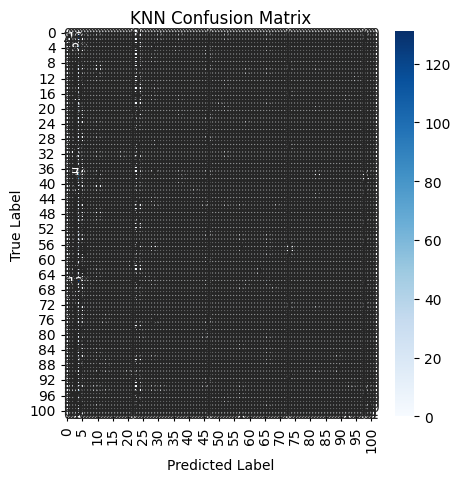

In [15]:
def plot_con_mat(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_con_mat(knn_con_mat, "KNN Confusion Matrix")

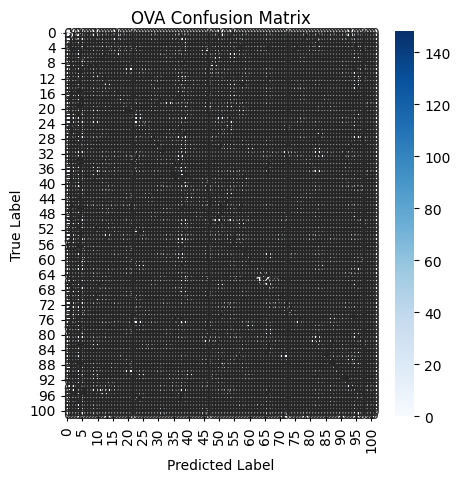

In [16]:
plot_con_mat(ova_con_mat, "OVA Confusion Matrix")

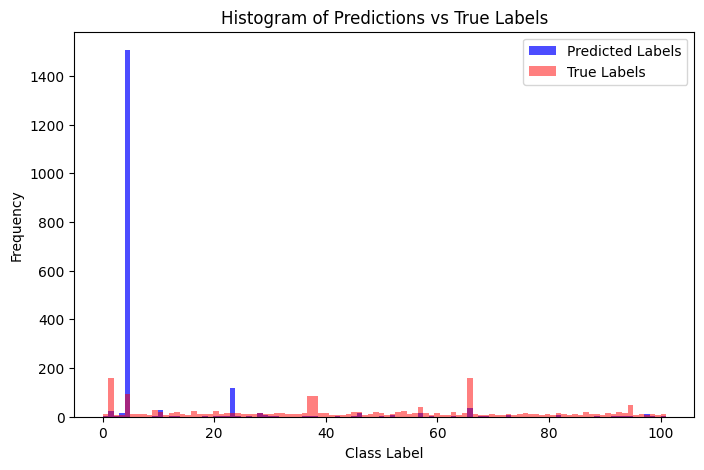

The general accuracy score is: 0.07725321888412018


In [17]:
def plot_histogram(predictions, test_classes, accuracy):
    plt.figure(figsize=(8, 5))
    plt.hist(predictions, bins=len(set(test_classes)), alpha=0.7, color='blue', label="Predicted Labels")
    plt.hist(test_classes, bins=len(set(test_classes)), alpha=0.5, color='red', label="True Labels")
    plt.xlabel("Class Label")
    plt.ylabel("Frequency")
    plt.title("Histogram of Predictions vs True Labels")
    plt.legend()
    plt.show()
    print(f'The general accuracy score is: {accuracy}')

plot_histogram(knn_pred, test_classes, knn_acc)

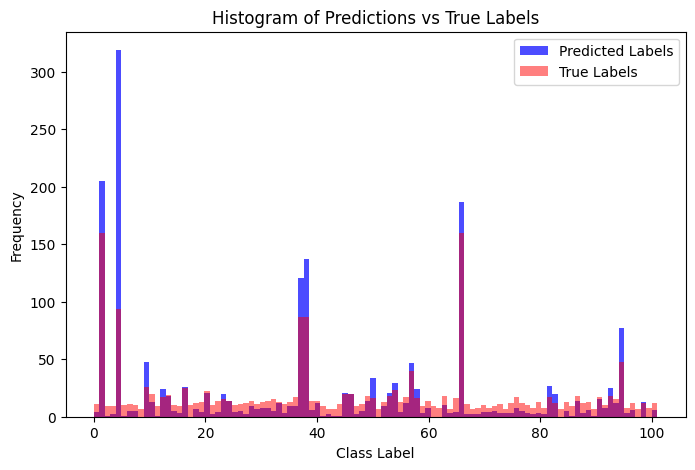

The general accuracy score is: 0.35783261802575106


In [18]:
plot_histogram(ova_pred, test_classes, ova_acc)

We finally save the classificators if we intend to use later.

In [19]:
joblib.dump(knn_classificator, 'res/knn_classifier.pkl')
joblib.dump(ova_classificator, 'res/ova_classifiers.pkl')

['res/ova_classifiers.pkl']

After testing, we can see that lower cluster sizes show the knn algorithm a significant classifying advantage compared to the svm kernel. On the contrary, higher cluster sizes benefit the svm kernel. Generally, the high class number makes both approaches inconsistent and inaccurate. For lower class numbers (~10), we can achieve a 60-70% accuracy, while now we barely can reach 30%. In the same repository, there is(or will be added shortly) an object classifier based on a convolutional neural network approach. Both pretrained and not models are used.